In [1]:
import pandas as pd
import numpy as np
import nltk
# nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_squared_error

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import shap


In [2]:
import numpy as np

In [3]:
import sklearn
sklearn.__version__ 

'1.4.2'

In [4]:
df_c19 = pd.read_csv("final_datasets/c19_final_2.csv")
df_m17 = pd.read_csv("final_datasets/m17_final_2.csv")
df_c19 = df_c19.sample(n=len(df_c19), random_state=42)
df_m17 = df_m17.sample(n=len(df_m17), random_state=42)

In [5]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stopword_list = nltk.corpus.stopwords.words("english")
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

def remove_stopwords(text):
    return " ".join([w for w in text if w not in stopword_list])

def remove_nonenglish(text):
    return "".join([i for i in text if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+",i)])

In [6]:
def preprocess_abstracts(df):
    df['abstract'] = df['abstract'].str.lower()
    df['abstract'] = df['abstract'].str.replace("\n", ' ')
    df['abstract'] = df['abstract'].str.replace("\d+", '', regex=True)
    df['abstract'] = df['abstract'].str.replace('[\*,\.!?\-\:\(\)_]', ' ', regex=True)
    df['abstract'] = df['abstract'].apply(lemmatize_text)
    df['abstract'] = df['abstract'].apply(remove_stopwords)
    df['abstract'] = df['abstract'].apply(remove_nonenglish)
    return df

In [7]:
df_m17 = preprocess_abstracts(df_m17)
df_c19 = preprocess_abstracts(df_c19)

In [7]:
def generateWordCloud(corpus: str, cmap: str):
    """
    Return a Word Cloud object generated from the corpus and color map parameter.
    """
    wordcloud = WordCloud(background_color = 'white', width = 800, height = 400,
                          colormap = cmap, max_words = 180, contour_width = 3,
                          max_font_size = 80, contour_color = 'steelblue',
                          random_state = 0)

    wordcloud.generate(corpus)

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

    return wordcloud

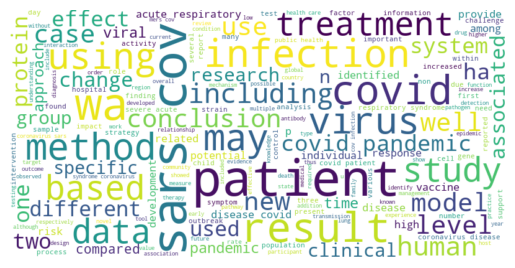

<Figure size 640x480 with 0 Axes>

In [8]:
generateWordCloud("".join(abstract for abstract in df_c19.abstract), cmap = 'viridis')

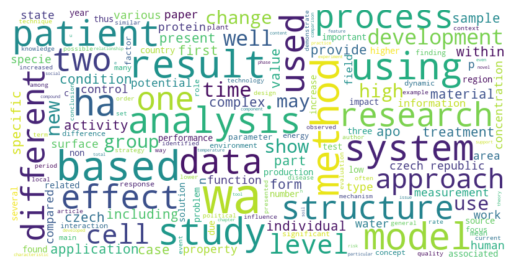

<Figure size 640x480 with 0 Axes>

In [9]:
generateWordCloud("".join(abstract for abstract in df_m17.abstract), cmap = 'viridis')

In [8]:
def tf_idf(train, test):
    vectorizer = TfidfVectorizer(max_features=1500, ngram_range=(1,3), min_df=0.005, max_df=0.80)
    train_tfidf = vectorizer.fit_transform(train['abstract'])
    test_tfdidf = vectorizer.transform(test['abstract'])
    return pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out()),  pd.DataFrame(test_tfdidf.toarray(), columns=vectorizer.get_feature_names_out())

In [9]:
def get_conf_matrix(y_test, y_pred):
    intensity = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = intensity, display_labels=set(y_test))
    disp.plot()

In [10]:
def get_train_test(X, y):
    X.drop(['evaluation', 'cited'], axis=1, errors='ignore', inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 42)
    return  X_train, X_test, y_train, y_test

In [11]:
X_train_m17, X_test_m17, y_train_m17, y_test_m17 = get_train_test(df_m17, df_m17['evaluation'])
X_train_c19, X_test_c19, y_train_c19, y_test_c19 = get_train_test(df_c19, df_c19['cited'])


In [12]:
X_train_c19_tfidf, X_test_c19_tfidf = tf_idf(X_train_c19,X_test_c19)
X_train_m17_tfidf, X_test_m17_tfidf = tf_idf(X_train_m17, X_test_m17)

In [19]:
X_train_c19_tfidf

,ability,able,absence,abstract,academic,access,according,account,accuracy,accurate,...,world health organization,worldwide,would,wuhan,wuhan china,year,year old,yet,yield,young
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,0.077164,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.082642,...,0.0,0.0,0.069335,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2394,0.000000,0.0,0.0,0.096660,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2395,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.069323,0.115758,0.0,0.0,0.060483
2396,0.000000,0.0,0.0,0.000000,0.0,0.0,0.068185,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [38]:
y_train_c19.reset_index(drop=True)

0       0
1       0
2       1
3       1
4       0
       ..
2393    1
2394    1
2395    0
2396    1
2397    0
Name: cited, Length: 2398, dtype: int64

In [10]:
df_c19

,title,abstract,cited,rigor,novelty,grammar,replicability,accessibility,mathematics,computer_sciences,...,exploratory_research,focus_groups,interviews,mixed_methods,observation,qualitative_research,quantitative_research,questionnaires,secondary_research,survey_methodology
1376,Poikilosis - pervasive biological variation.,biological system dynamic display heterogeneit...,0,medium,high,0,0,high,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
932,PI3Kδ Inhibition as a Potential Therapeutic Ta...,spread novel human respiratory coronavirus sar...,0,high,high,0,1,high,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
144,Disinfection of Wastewater by UV-Based Treatme...,among critical issue prevent reuse wastewater ...,0,high,high,0,1,high,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1752,Targeting Toll-Like Receptors: Promising Thera...,toll like receptor tlrs pattern recognition re...,1,high,high,0,1,high,1.0,1.0,...,1,0,0,1,0,1,1,0,1,0
51,Exploring values among three cultures from a g...,united nation educational scientific cultural ...,0,medium,high,0,0,high,0.0,0.0,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,Patterns of Positive Selection in Six Mammalia...,genome wide scan positively selected gene psgs...,1,high,high,0,1,high,0.0,0.0,...,1,0,0,1,1,1,1,0,1,1
1095,Estimating individual risks of COVID-19-associ...,describe method estimate individual risk hospi...,0,high,high,0,1,high,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1130,Teaching Chemistry with Arduino Experiments in...,study k greek student wa conducted order evalu...,0,high,high,0,1,high,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1294,Respiratory muscle function in the newborn: a ...,abstract aim wa summarise current evidence met...,0,high,high,1,1,high,0.0,0.0,...,1,0,0,1,0,1,1,0,0,0


In [13]:
X_train_c19

,ability,able,absence,abstract,academic,access,according,account,accuracy,accurate,...,world health organization,worldwide,would,wuhan,wuhan china,year,year old,yet,yield,young
1569,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
2228,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
2295,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
1800,0.076155,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
1273,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.08617,...,0.0,0.0,0.072357,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
1095,0.000000,0.0,0.0,0.099186,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
1130,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.069749,0.114985,0.0,0.0,0.05922
1294,0.000000,0.0,0.0,0.000000,0.0,0.0,0.068864,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000


In [14]:
y_train_c19

545     0
624     0
2739    1
2786    1
394     0
       ..
2619    1
2078    1
890     0
2517    1
802     0
Name: cited, Length: 2398, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = X_train_m17, X_test_m17, y_train_m17, y_test_m17
y_train = y_train - 1 
y_test = y_test -1 
# Split the data into training and testing sets

# Build the neural network model
model = Sequential()

# First Dense layer with Batch Normalization
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Dense layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer for 5-class classification
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.002, restore_best_weights=True),
]
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred = y_pred + 1 
y_test = y_test + 1
display(f"Multilayer Perceptron with TF-IDF Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF MAE score: {mean_absolute_error(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF RMSE score: {root_mean_squared_error(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF MSE score: {mean_squared_error(y_test, y_pred)}")
get_conf_matrix(y_test=y_test, y_pred=y_pred)

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


ValueError: could not convert string to float: 'Structure and genome ejection mechanism of Staphylococcus aureus phage P68'

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5073 - loss: 0.9461 - val_accuracy: 0.5042 - val_loss: 0.6909
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6740 - loss: 0.6294 - val_accuracy: 0.5250 - val_loss: 0.6889
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7049 - loss: 0.5716 - val_accuracy: 0.5500 - val_loss: 0.6850
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7924 - loss: 0.4493 - val_accuracy: 0.5583 - val_loss: 0.6881
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8425 - loss: 0.3615 - val_accuracy: 0.5458 - val_loss: 0.7128
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8806 - loss: 0.2950 - val_accuracy: 0.5583 - val_loss: 0.7577
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9161 - loss: 0.2295 - val_accuracy: 0.6000 - val_loss: 0.8204
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.1903 - val_accuracy: 0.6167 - val_loss:

'Multilayer Perceptron with TF-IDF Accuracy score: 0.5966666666666667'

'Multilayer Perceptron with TF-IDF Recall score: 0.5940408645539565'

'Multilayer Perceptron with TF-IDF F1 score: 0.5940687063875469'

'Multilayer Perceptron with TF-IDF Precision score: 0.5947506148990891'

'Multilayer Perceptron with TF-IDF MAE score: 0.4033333333333333'

'Multilayer Perceptron with TF-IDF RMSE score: 0.6350852961085883'

'Multilayer Perceptron with TF-IDF MSE score: 0.4033333333333333'

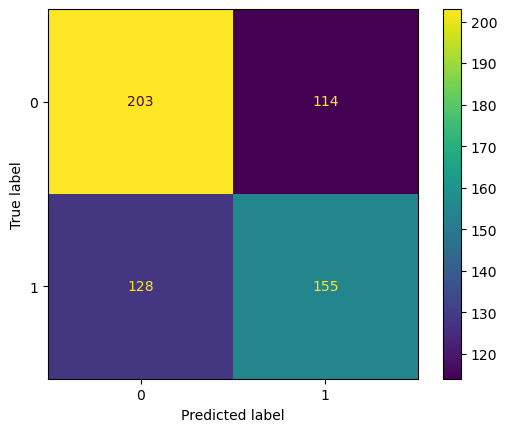

In [101]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = X_train_c19, X_test_c19, y_train_c19, y_test_c19

model = Sequential()

# First Dense layer with Batch Normalization
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Dense layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))




# Third Dense layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(f'Predictions: {y_pred.flatten()}')  # Predictions for binary classification

display(f"Multilayer Perceptron with TF-IDF Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF MAE score: {mean_absolute_error(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF RMSE score: {root_mean_squared_error(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF MSE score: {mean_squared_error(y_test, y_pred)}")
get_conf_matrix(y_test=y_test, y_pred=y_pred)

In [17]:
grid_rfc = {
    'max_depth': [20, 30, 40, 100],
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [30,  45, 90, 120],
    'min_samples_split': [20, 50, 90],
    'n_estimators': [ 100, 300, 500]}

grid_abc = {
    'n_estimators': [ 100, 200, 400, 1000],
    'learning_rate': [0.1, 0.2, 0.4, 1, 1.5]}

In [12]:

def train_rfc(X_train, y_train, X_test, y_test , metric = None):
    rf = RandomForestClassifier()
    rf_grid = RandomizedSearchCV(estimator = rf, param_distributions= grid_rfc, n_iter= 2000, cv = 5, verbose=3, n_jobs = -1, scoring=metric,random_state=42)
    rf_grid.fit(X_train, y_train)
    best = rf_grid.best_estimator_
    y_pred = best.predict(X_test)
    display(f"Best params: {rf_grid.best_params_}")
    display(f"Random Forest Classifier Accuracy score: {accuracy_score(y_test, y_pred)}")
    display(f"Random Forest Classifier Recall score: {recall_score(y_test, y_pred, average='macro')}")
    display(f"Random Forest Classifier F1 score: {f1_score(y_test, y_pred, average='macro')}")
    display(f"Random Forest Classifier Precision score: {precision_score(y_test, y_pred, average='macro')}")
    display(f"Random Forest Classifier MAE score: {mean_absolute_error(y_test, y_pred)}")
    display(f"Random Forest Classifier RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    display(f"Random Forest Classifier MSE score: {mean_squared_error(y_test, y_pred)}")
    get_conf_matrix(y_test, y_pred)

    result = permutation_importance(
        best, X_test, y_test, n_repeats=30, random_state=42, n_jobs=2
    )
    forest_importances = pd.Series(result.importances_mean, index=X_train.columns)
    forest_importances = forest_importances.sort_values(ascending=False)[:16]
    display(forest_importances)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

def train_gbc(X_train, y_train, X_test, y_test, metric = None):
    gbc = GradientBoostingClassifier()
    gbc_grid = RandomizedSearchCV(estimator = gbc, n_iter=2000 , param_distributions = grid_rfc, cv = 5, verbose=3, n_jobs = -1, scoring=metric, random_state=42)
    gbc_grid.fit(X_train, y_train)
    best = gbc_grid.best_estimator_

    y_pred = gbc_grid.predict(X_test)
    display(f"Best params: {gbc_grid.best_params_}")
    display(f"Gradient Boosting Classifier Accuracy score: {accuracy_score(y_test, y_pred)}")
    display(f"Gradient Boosting Classifier Recall score: {recall_score(y_test, y_pred, average='macro')}")
    display(f"Gradient Boosting Classifier F1 score: {f1_score(y_test,  y_pred, average='macro')}")
    display(f"Gradient Boosting Classifier Precision score: {precision_score(y_test, y_pred, average='macro')}")
    display(f"Gradient Boosting Classifier MAE score: {mean_absolute_error(y_test, y_pred)}")
    display(f"Gradient Boosting Classifier RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    display(f"Gradient Boosting Classifier MSE score: {mean_squared_error(y_test, y_pred)}")
    get_conf_matrix(y_test, y_pred)


    result = permutation_importance(
        best, X_test, y_test, n_repeats=30, random_state=42, n_jobs=2
    )
    forest_importances = pd.Series(result.importances_mean, index=X_train.columns)
    forest_importances = forest_importances.sort_values(ascending=False)[:16]
    display(forest_importances)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()


def train_abc(X_train, y_train, X_test, y_test, metric = None ):
    abc = AdaBoostClassifier()
    abc_grid = RandomizedSearchCV(estimator = abc, n_iter=2000 , param_distributions = grid_abc, cv = 5, verbose=3, n_jobs = -1, scoring=metric,random_state=42 )
    abc_grid.fit(X_train, y_train)
    best = abc_grid.best_estimator_

    y_pred = abc_grid.predict(X_test)
    display(f"Best params: {abc_grid.best_params_}")
    display(f"Ada Boosting Classifier Accuracy score: {accuracy_score(y_test, y_pred)}")
    display(f"Ada Boosting Classifier Recall score: {recall_score(y_test, y_pred, average='macro')}")
    display(f"Ada Boosting Classifier F1 score: {f1_score(y_test,  y_pred, average='macro')}")
    display(f"Ada Boosting Classifier Precision score: {precision_score(y_test, y_pred, average='macro')}")
    display(f"Ada Boosting Classifier MAE score: {mean_absolute_error(y_test, y_pred)}")
    display(f"Ada Boosting Classifier RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    display(f"Ada Boosting Classifier MSE score: {mean_squared_error(y_test, y_pred)}")
    get_conf_matrix(y_test, y_pred)

    result = permutation_importance(
        best, X_test, y_test, n_repeats=30, random_state=42, n_jobs=2
    )
    forest_importances = pd.Series(result.importances_mean, index=X_train.columns)
    forest_importances = forest_importances.sort_values(ascending=False)[:16]
    display(forest_importances)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

def train_svm(X_train, y_train, X_test, y_test, metric = 'accuracy'):
    svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    display(f"SVM Accuracy score: {accuracy_score(y_test, y_pred)}")
    display(f"SVM Recall score: {recall_score(y_test, y_pred, average='macro')}")
    display(f"SVM F1 score: {f1_score(y_test, y_pred, average='macro')}")
    display(f"SVM Precision score: {precision_score(y_test, y_pred, average='macro')}")
    display(f"SVM MAE score: {mean_absolute_error(y_test, y_pred)}")
    display(f"SVM RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    display(f"SVM MSE score: {mean_squared_error(y_test, y_pred)}")
    get_conf_matrix(y_test, y_pred)

def train_logreg(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_orig = X_train
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    logistic_regression_cv_model = LogisticRegressionCV(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=10000,
        cv=5,
        random_state=42
    )
    logistic_regression_cv_model.fit(X_train, y_train)

    coefficients = logistic_regression_cv_model.coef_
    intercept = logistic_regression_cv_model.intercept_

    coefficients_df = pd.DataFrame(coefficients, columns=[col for col in X_train_orig.columns])
    coefficients_df['Intercept'] = intercept
    y_pred = logistic_regression_cv_model.predict(X_test)
    display(coefficients_df)
    display(f"Logreg Accuracy score: {accuracy_score(y_test, y_pred)}")
    display(f"Logreg Recall score: {recall_score(y_test, y_pred, average='macro')}")
    display(f"Logreg F1 score: {f1_score(y_test, y_pred, average='macro')}")
    display(f"Logreg Precision score: {precision_score(y_test, y_pred, average='macro')}")
    display(f"Logreg MAE score: {mean_absolute_error(y_test, y_pred)}")
    display(f"Logreg RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    display(f"Logreg MSE score: {mean_squared_error(y_test, y_pred)}")
    get_conf_matrix(y_test, y_pred)

    result = permutation_importance(
        logistic_regression_cv_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=2
    )
    forest_importances = pd.Series(result.importances_mean, index=X_train_orig.columns)
    forest_importances = forest_importances.sort_values(ascending=False)[:16]
    display(forest_importances)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()



def train_sm_logreg(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_orig = X_train
    

    model = sm.MNLogit(y_train, X_train)
    model_fit = model.fit(method='bfgs', maxiter=1000)
    y_pred = model_fit.predict(X_test)
    print(model_fit.summary())
    print(np.array(y_pred))

    offset = 0 if len(set(y_train)) == 2 else 1
    y_pred = [list(pred).index(max(pred)) + offset for pred in np.array(y_pred)]
    display(f"Logreg Accuracy score: {accuracy_score(y_test, y_pred)}")
    display(f"Logreg Recall score: {recall_score(y_test, y_pred, average='macro')}")
    display(f"Logreg F1 score: {f1_score(y_test, y_pred, average='macro')}")
    display(f"Logreg Precision score: {precision_score(y_test, y_pred, average='macro')}")
    display(f"Logreg MAE score: {mean_absolute_error(y_test, y_pred)}")
    display(f"Logreg RMSE score: {root_mean_squared_error(y_test, y_pred)}")
    display(f"Logreg MSE score: {mean_squared_error(y_test, y_pred)}")
    get_conf_matrix(y_test, y_pred)


'SVM Accuracy score: 0.6166666666666667'

'SVM Recall score: 0.6169477544559753'

'SVM F1 score: 0.6163213558869649'

'SVM Precision score: 0.6165735174835276'

'SVM MAE score: 0.38333333333333336'

'SVM RMSE score: 0.6191391873668903'

'SVM MSE score: 0.38333333333333336'

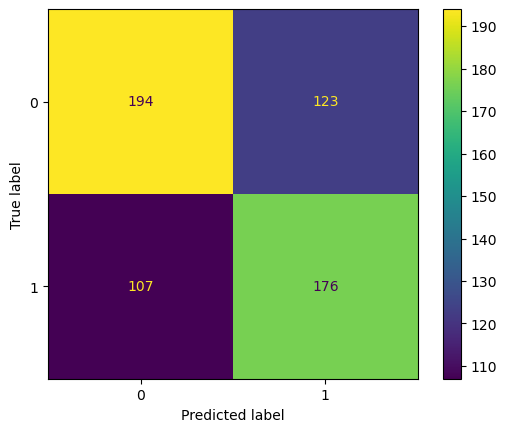

In [90]:
train_svm(X_train=X_train_c19, y_train=y_train_c19, X_test=X_test_c19, y_test=y_test_c19)

In [178]:
X_train_c19

,ability,able,absence,abstract,academic,access,according,account,accuracy,accurate,...,world health organization,worldwide,would,wuhan,wuhan china,year,year old,yet,yield,young
858,0.0,0.000000,0.0,0.000000,0.0,0.112365,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
1011,0.0,0.067351,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
48,0.0,0.000000,0.0,0.098997,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
719,0.0,0.000000,0.0,0.165945,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
1487,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
1095,0.0,0.000000,0.0,0.099186,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
1130,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.069749,0.114985,0.0,0.0,0.05922
1294,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.068864,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000


In [179]:
y_train_c19

596     0
2536    1
1737    1
1565    1
2322    1
       ..
2619    1
2078    1
890     0
2517    1
802     0
Name: cited, Length: 2098, dtype: int64

The total space of parameters 20 is smaller than n_iter=1000. Running 20 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.


"Best params: {'n_estimators': 200, 'learning_rate': 0.1}"

'Ada Boosting Classifier Accuracy score: 0.625'

'Ada Boosting Classifier Recall score: 0.6223707237685456'

'Ada Boosting Classifier F1 score: 0.6224821657778685'

'Ada Boosting Classifier Precision score: 0.6233815860456753'

'Ada Boosting Classifier MAE score: 0.375'

'Ada Boosting Classifier RMSE score: 0.6123724356957945'

'Ada Boosting Classifier MSE score: 0.375'

[0.035 0.03  0.025 0.025 0.025 0.02  0.02  0.02  0.02  0.02  0.02  0.02
 0.02  0.015 0.015 0.015]
Index(['virus', 'china', 'study wa', 'experience', 'social distancing', 'home',
       'viral', 'infection', 'right', 'recent', 'novel', 'index', 'severe',
       'transmission', 'coronavirus', 'molecule'],
      dtype='object')


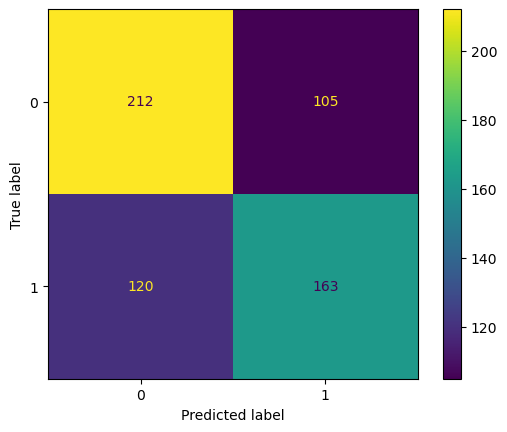

<Figure size 10000x3000 with 0 Axes>

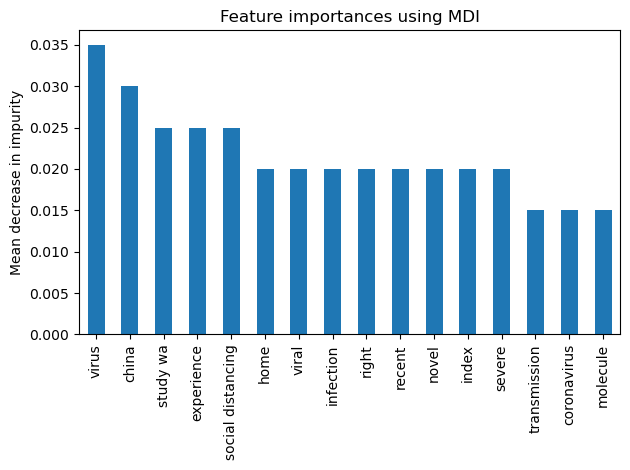

In [91]:
train_abc(X_train=X_train_c19, y_train=y_train_c19, X_test=X_test_c19, y_test=y_test_c19)

The total space of parameters 20 is smaller than n_iter=1000. Running 20 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.


"Best params: {'n_estimators': 200, 'learning_rate': 1}"

'Ada Boosting Classifier Accuracy score: 0.26'

'Ada Boosting Classifier Recall score: 0.2595224248219177'

'Ada Boosting Classifier F1 score: 0.25634695193731527'

'Ada Boosting Classifier Precision score: 0.277012080864388'

'Ada Boosting Classifier MAE score: 1.3'

'Ada Boosting Classifier RMSE score: 1.697056274847714'

'Ada Boosting Classifier MSE score: 2.88'

[0.025 0.02  0.015 0.015 0.015 0.015 0.015 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01 ]
Index(['outcome', 'learning', 'mechanism', 'artery', 'associated', 'invasive',
       'cell', 'whereas', 'core', 'substantially', 'age', 'mapping', 'vivo',
       'profile', 'spatial', 'upon'],
      dtype='object')


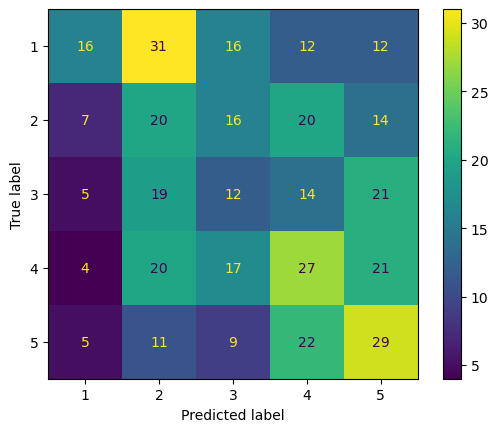

<Figure size 10000x3000 with 0 Axes>

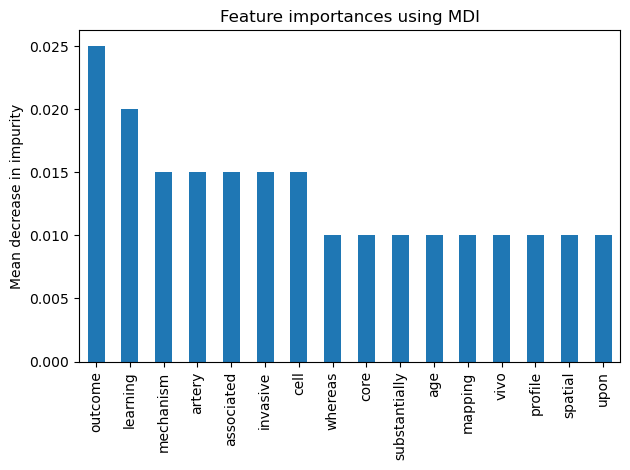

In [92]:
train_abc(X_train_m17, y_train_m17,X_test_m17, y_test_m17)

'SVM Accuracy score: 0.3425'

'SVM Recall score: 0.33778951787481354'

'SVM F1 score: 0.3321493099895995'

'SVM Precision score: 0.3285783644456983'

'SVM MAE score: 1.0725'

'SVM RMSE score: 1.4908051515875576'

'SVM MSE score: 2.2225'

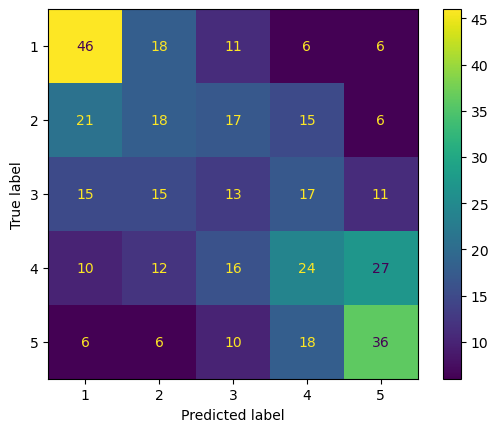

In [93]:
train_svm(X_train_m17, y_train_m17,X_test_m17, y_test_m17)

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.


,rigor,novelty,grammar,replicability,accessibility,mathematics,computer_sciences,physical_sciences,chemical_sciences,earth_and_related_sciences,...,focus_groups,interviews,mixed_methods,observation,qualitative_research,quantitative_research,questionnaires,secondary_research,survey_methodology,Intercept
0,0.043348,0.020036,-0.000695,0.000937,-0.011819,-0.001072,0.003976,0.013959,0.0225,0.016295,...,-0.011547,-0.004729,-0.001996,0.001293,-0.017806,-0.007455,-0.022684,0.007479,-0.009852,0.015432


'Logreg Accuracy score: 0.5733333333333334'

'Logreg Recall score: 0.5689268874496995'

'Logreg F1 score: 0.5681074332759726'

'Logreg Precision score: 0.5705887053505176'

'Logreg MAE score: 0.4266666666666667'

'Logreg RMSE score: 0.6531972647421809'

'Logreg MSE score: 0.4266666666666667'

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

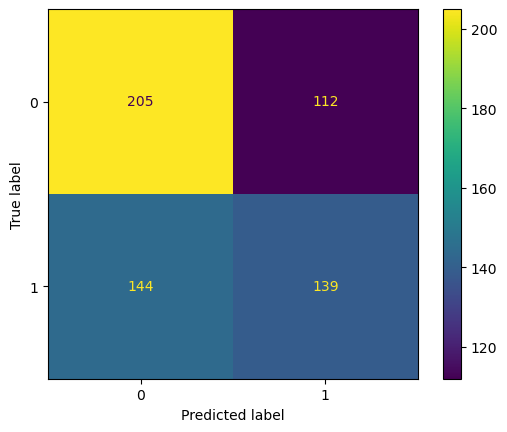

In [175]:
train_logreg(X_train=X_train_c19, y_train=y_train_c19, X_test=X_test_c19, y_test=y_test_c19)

'SVM Accuracy score: 0.6166666666666667'

'SVM Recall score: 0.6169477544559753'

'SVM F1 score: 0.6163213558869649'

'SVM Precision score: 0.6165735174835276'

'SVM MAE score: 0.38333333333333336'

'SVM RMSE score: 0.6191391873668903'

'SVM MSE score: 0.38333333333333336'

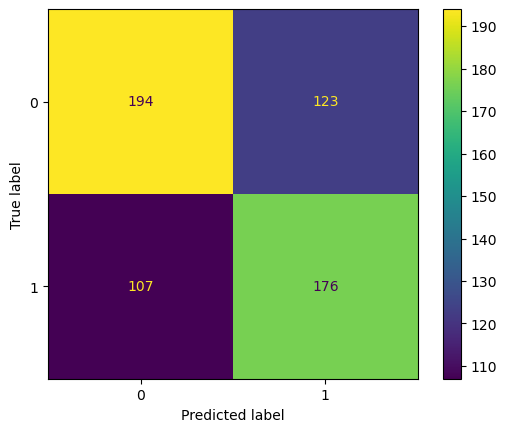

In [95]:
train_svm(X_train=X_train_c19, y_train=y_train_c19, X_test=X_test_c19, y_test=y_test_c19)

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.


,ability,able,academic,access,accompanied,according,account,accuracy,accurate,achieve,...,world,worldwide,would,wt,year,yet,yield,young,zone,Intercept
0,0.001509,-0.000914,-0.000948,0.002407,0.000126,-0.003443,-0.001056,0.001199,0.001393,-0.000570,...,-0.000946,0.000200,-0.002346,-0.001783,-0.000222,0.004359,0.001305,-0.000494,-0.000580,-0.027888
1,-0.003439,0.001355,0.000773,-0.001872,0.001289,0.001116,0.002691,-0.000850,-0.001131,-0.000852,...,0.001341,0.001378,0.000135,0.001297,0.001600,0.000056,0.001951,-0.001905,0.000877,0.012670
2,0.001109,-0.000090,0.001144,0.001435,-0.001629,0.001041,0.002137,0.000357,0.000356,-0.000039,...,-0.000314,-0.000552,0.000368,0.002711,0.000776,-0.002260,0.001638,0.001582,-0.000641,0.033729
3,0.000477,-0.001756,-0.001075,0.001004,-0.000266,0.000330,-0.000956,-0.001362,-0.001903,0.000462,...,-0.001474,-0.001313,0.001692,0.000093,0.000391,0.000430,-0.001873,-0.000149,0.001499,-0.026433
4,0.000345,0.001405,0.000106,-0.002973,0.000481,0.000957,-0.002816,0.000656,0.001285,0.000999,...,0.001393,0.000286,0.000151,-0.002318,-0.002545,-0.002585,-0.003021,0.000966,-0.001155,0.007922


'Logreg Accuracy score: 0.33'

'Logreg Recall score: 0.3321818863837016'

'Logreg F1 score: 0.3025031519363213'

'Logreg Precision score: 0.30179430897701615'

'Logreg MAE score: 1.09'

'Logreg RMSE score: 1.5083103128998356'

'Logreg MSE score: 2.275'

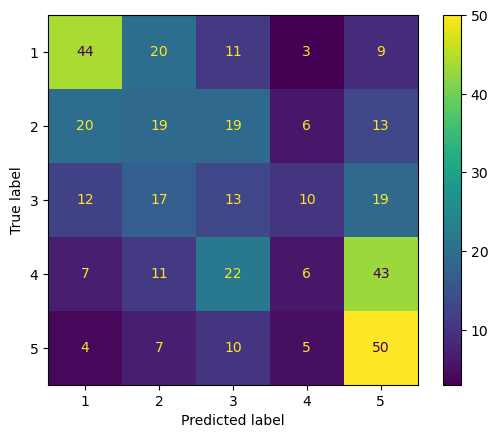

In [96]:
train_logreg(X_train_m17, y_train_m17,X_test_m17, y_test_m17)

The total space of parameters 288 is smaller than n_iter=1000. Running 288 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


"Best params: {'n_estimators': 500, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_features': 'log2', 'max_depth': 30}"

'Random Forest Classifier Accuracy score: 0.6216666666666667'

'Random Forest Classifier Recall score: 0.6230060973570688'

'Random Forest Classifier F1 score: 0.6216151642862501'

'Random Forest Classifier Precision score: 0.6227474972191324'

'Random Forest Classifier MAE score: 0.37833333333333335'

'Random Forest Classifier RMSE score: 0.6150880695748645'

'Random Forest Classifier MSE score: 0.37833333333333335'

[0.0254777  0.01833392 0.01279841 0.01241807 0.01024717 0.00963
 0.00951128 0.00942611 0.00889438 0.00862343 0.00790071 0.00786016
 0.00768445 0.0068004  0.00674227 0.0064695 ]
Index(['virus', 'viral', 'infection', 'host', 'protein', 'management',
       'result', 'rna', 'study', 'cell', 'china', 'coronavirus', 'disease',
       'experience', 'sequence', 'replication'],
      dtype='object')


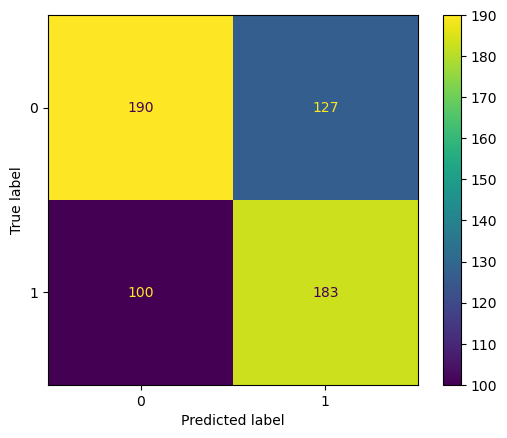

<Figure size 10000x3000 with 0 Axes>

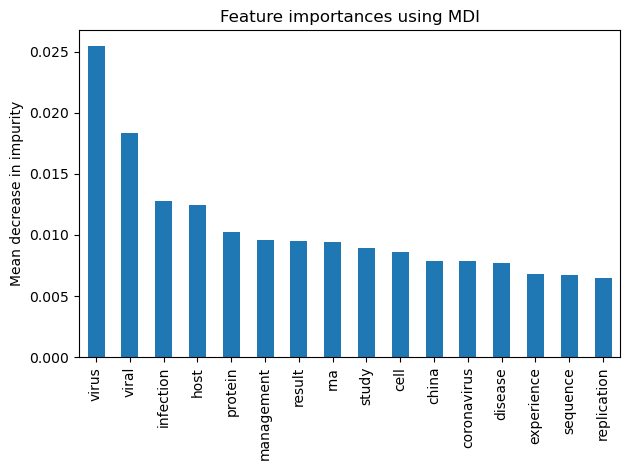

In [97]:
train_rfc(X_train=X_train_c19, y_train=y_train_c19, X_test=X_test_c19, y_test=y_test_c19)

The total space of parameters 288 is smaller than n_iter=1000. Running 288 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


"Best params: {'n_estimators': 300, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_features': 'log2', 'max_depth': 20}"

'Random Forest Classifier Accuracy score: 0.335'

'Random Forest Classifier Recall score: 0.3416412881221862'

'Random Forest Classifier F1 score: 0.3071731975494755'

'Random Forest Classifier Precision score: 0.3606288070914311'

'Random Forest Classifier MAE score: 1.1575'

'Random Forest Classifier RMSE score: 1.6054594358002323'

'Random Forest Classifier MSE score: 2.5775'

[0.01804249 0.01636371 0.01603196 0.01428025 0.01418449 0.01287023
 0.01272374 0.01182703 0.01116378 0.01077007 0.01028922 0.01016422
 0.00984018 0.00963114 0.00948395 0.00937519]
Index(['show', 'method', 'protein', 'cell', 'republic', 'czech', 'paper',
       'aim', 'deal', 'chapter', 'may', 'gene', 'molecular', 'mechanism',
       'analysis', 'complex'],
      dtype='object')


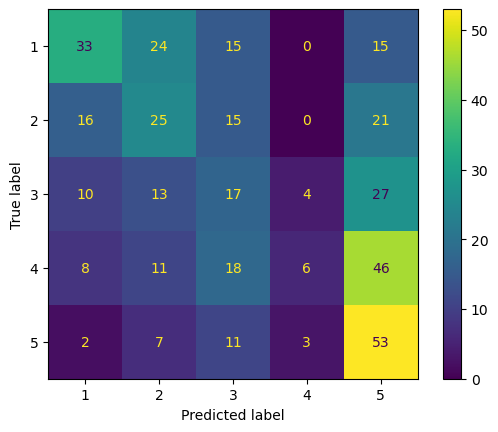

<Figure size 10000x3000 with 0 Axes>

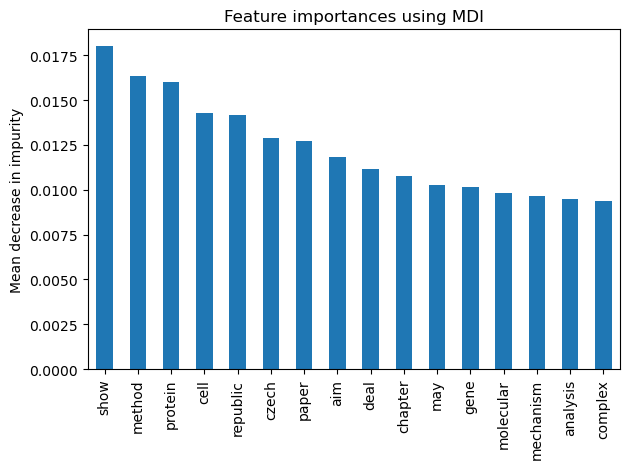

In [98]:
train_rfc(X_train_m17, y_train_m17,X_test_m17, y_test_m17)

Ahoj


paper          0.013500
view           0.012417
aim            0.009583
mechanism      0.009000
context        0.007833
measurement    0.007667
review         0.007667
background     0.007417
within         0.007000
nature         0.007000
well           0.006667
also           0.006500
property       0.006167
information    0.006083
across         0.005917
scale          0.005833
dtype: float64

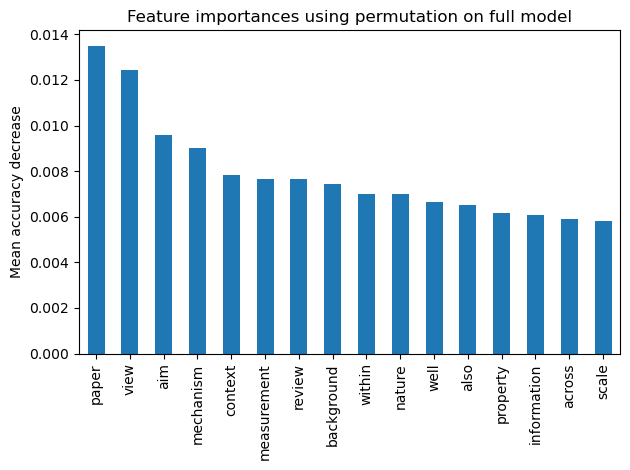

In [107]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance

 # 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_features': 'log2', 'max_depth': 20
mdl = GradientBoostingClassifier(n_estimators = 300, min_samples_leaf = 30, max_features='log2', max_depth=20, random_state=42)
mdl.fit(X_train_m17, y_train_m17)
print("Ahoj")
y_pred = mdl.predict(X_test_m17)
result = permutation_importance(
    mdl, X_test, y_test, n_repeats=30, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)
forest_importances = forest_importances.sort_values(ascending=False)[:16]
display(forest_importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

The total space of parameters 288 is smaller than n_iter=1000. Running 288 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


"Best params: {'n_estimators': 100, 'min_samples_split': 90, 'min_samples_leaf': 30, 'max_features': 'log2', 'max_depth': 20}"

'Gradient Boosting Classifier Accuracy score: 0.61'

'Gradient Boosting Classifier Recall score: 0.6100701140328388'

'Gradient Boosting Classifier F1 score: 0.6095661846496107'

'Gradient Boosting Classifier Precision score: 0.6097276394306097'

'Gradient Boosting Classifier MAE score: 0.39'

'Gradient Boosting Classifier RMSE score: 0.6244997998398398'

'Gradient Boosting Classifier MSE score: 0.39'

[0.02420353 0.00970412 0.0077352  0.00771385 0.0073026  0.0071083
 0.00700673 0.00657212 0.0065687  0.00649088 0.00594908 0.0054761
 0.00546046 0.00539406 0.00537491 0.00532425]
Index(['virus', 'viral', 'molecule', 'management', 'novel', 'old', 'study wa',
       'china', 'recent', 'home', 'public health', 'control', 'cancer',
       'study', 'type', 'social distancing'],
      dtype='object')


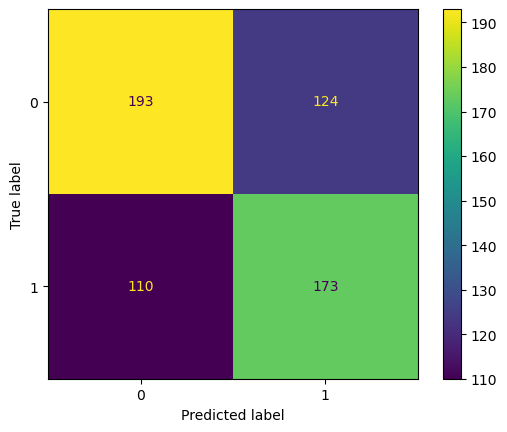

<Figure size 10000x3000 with 0 Axes>

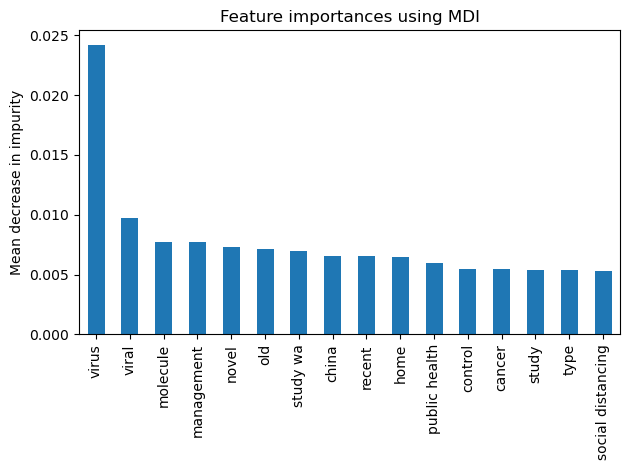

In [99]:
train_gbc(X_train=X_train_c19, y_train=y_train_c19, X_test=X_test_c19, y_test=y_test_c19)

The total space of parameters 288 is smaller than n_iter=2000. Running 288 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


"Best params: {'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 45, 'max_features': 'log2', 'max_depth': 20}"

'Gradient Boosting Classifier Accuracy score: 0.3725'

'Gradient Boosting Classifier Recall score: 0.3691723498906715'

'Gradient Boosting Classifier F1 score: 0.3572705624772045'

'Gradient Boosting Classifier Precision score: 0.3585399109110449'

'Gradient Boosting Classifier MAE score: 1.08'

'Gradient Boosting Classifier RMSE score: 1.5313392831113555'

'Gradient Boosting Classifier MSE score: 2.345'

analysis     0.013250
long         0.012417
patient      0.011917
study        0.011583
using        0.010417
compared     0.009750
aim          0.009583
main         0.009250
show         0.009167
however      0.008583
mechanism    0.007833
political    0.007833
increased    0.007583
necessary    0.007583
impact       0.007000
known        0.006750
dtype: float64

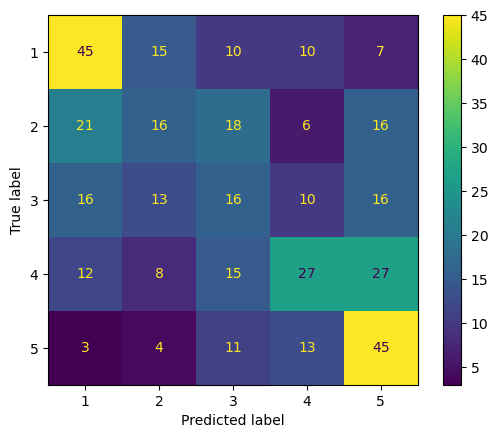

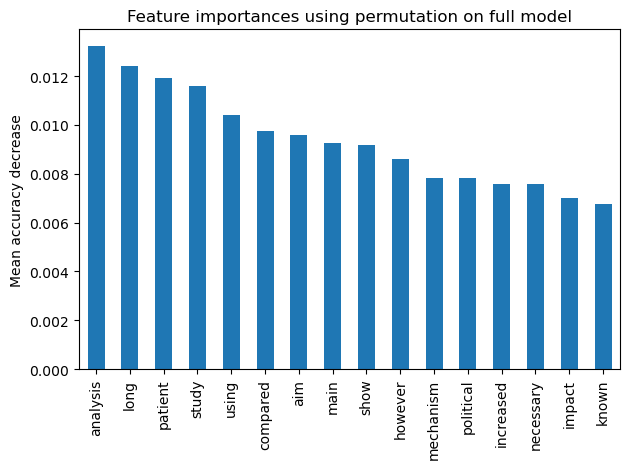

In [22]:
train_gbc(X_train=X_train_m17_tfidf, y_train=y_train_m17, X_test=X_test_m17_tfidf, y_test=y_test_m17)

## TF-IDF + features

In [13]:
enc = OrdinalEncoder(categories=[['low', 'medium', 'high']])

def encode(df):
    df.drop(['title', 'abstract', 'science_field', 'collaborators', 'journal_name'], axis = 1, inplace = True, errors='ignore')
    df['rigor'] = enc.fit_transform(df[['rigor']])
    df['novelty'] = enc.fit_transform(df[['novelty']])
    df['accessibility'] = enc.fit_transform(df[['accessibility']])

In [14]:
X_train_c19_tfidf

,ability,able,absence,abstract,academic,access,according,account,accuracy,accurate,...,world health organization,worldwide,would,wuhan,wuhan china,year,year old,yet,yield,young
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,0.077164,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.082642,...,0.0,0.0,0.069335,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2394,0.000000,0.0,0.0,0.096660,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2395,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.069323,0.115758,0.0,0.0,0.060483
2396,0.000000,0.0,0.0,0.000000,0.0,0.0,0.068185,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [15]:
encode(X_train_c19)
encode(X_test_c19)
encode(X_train_m17)
encode(X_test_m17)

In [16]:
X_train_c19_comb = pd.concat([X_train_c19.reset_index(drop=True), X_train_c19_tfidf.reset_index(drop=True)], axis=1)
X_test_c19_comb = pd.concat([X_test_c19.reset_index(drop=True), X_test_c19_tfidf.reset_index(drop=True)], axis=1)
X_train_m17_comb = pd.concat([X_train_m17.reset_index(drop=True), X_train_m17_tfidf.reset_index(drop=True)], axis=1)
X_test_m17_comb = pd.concat([X_test_m17.reset_index(drop=True), X_test_m17_tfidf.reset_index(drop=True)], axis=1)

### Random forest

The total space of parameters 288 is smaller than n_iter=2000. Running 288 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


"Best params: {'n_estimators': 300, 'min_samples_split': 90, 'min_samples_leaf': 45, 'max_features': 'log2', 'max_depth': 100}"

'Random Forest Classifier Accuracy score: 0.6416666666666667'

'Random Forest Classifier Recall score: 0.6426915316962245'

'Random Forest Classifier F1 score: 0.641546186357081'

'Random Forest Classifier Precision score: 0.6422902494331066'

'Random Forest Classifier MAE score: 0.35833333333333334'

'Random Forest Classifier RMSE score: 0.5986094998689324'

'Random Forest Classifier MSE score: 0.35833333333333334'

protein              0.007000
positive             0.005444
replicability        0.005389
physical_sciences    0.005111
research             0.005056
may                  0.004889
negative             0.004611
computer_sciences    0.004333
type                 0.003944
sample               0.003889
chemical_sciences    0.003778
novel                0.003722
influenza            0.003611
potential            0.003500
main                 0.003389
national             0.003333
dtype: float64

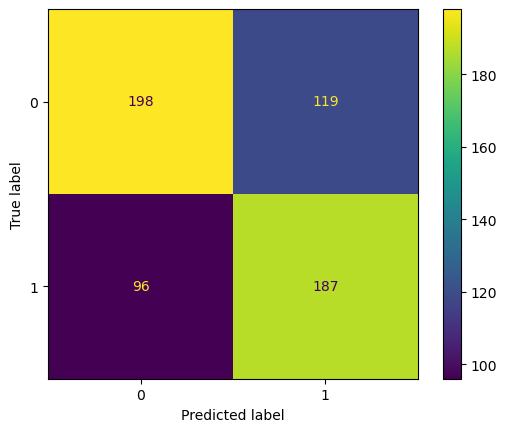

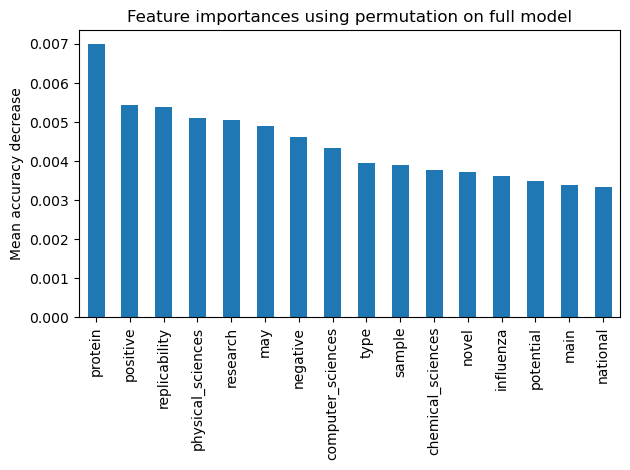

In [139]:
train_rfc(X_train=X_train_c19_comb, y_train=y_train_c19, X_test=X_test_c19_comb, y_test=y_test_c19)

The total space of parameters 288 is smaller than n_iter=2000. Running 288 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


"Best params: {'n_estimators': 300, 'min_samples_split': 50, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'max_depth': 20}"

'Random Forest Classifier Accuracy score: 0.3475'

'Random Forest Classifier Recall score: 0.34289260120955156'

'Random Forest Classifier F1 score: 0.26175074078941174'

'Random Forest Classifier Precision score: 0.4051218062982769'

'Random Forest Classifier MAE score: 1.2725'

'Random Forest Classifier RMSE score: 1.7797471730557686'

'Random Forest Classifier MSE score: 3.1675'

rigor                  0.023167
novelty                0.015667
based                  0.010833
biological_sciences    0.008833
may                    0.006500
result                 0.006417
paper                  0.006000
grammar                0.005750
state                  0.004833
level                  0.004583
concentration          0.004500
show                   0.004333
czech                  0.004333
one                    0.004333
patient                0.004250
year                   0.004000
dtype: float64

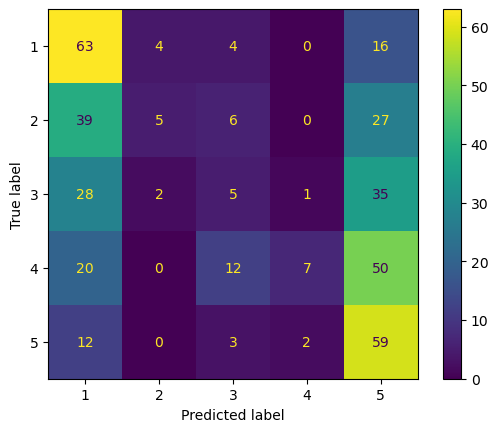

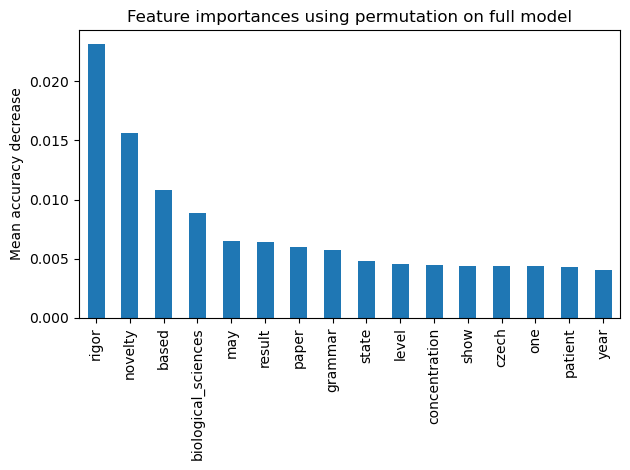

In [159]:
train_rfc(X_train_m17_comb, y_train_m17, X_test_m17_comb, y_test_m17)

## Gradient Boost Classificator

The total space of parameters 288 is smaller than n_iter=2000. Running 288 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


"Best params: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 45, 'max_features': 'log2', 'max_depth': 40}"

'Gradient Boosting Classifier Accuracy score: 0.65'

'Gradient Boosting Classifier Recall score: 0.6505779670274549'

'Gradient Boosting Classifier F1 score: 0.6497509339975094'

'Gradient Boosting Classifier Precision score: 0.6500961121790242'

'Gradient Boosting Classifier MAE score: 0.35'

'Gradient Boosting Classifier RMSE score: 0.5916079783099616'

'Gradient Boosting Classifier MSE score: 0.35'

result                      0.011833
using                       0.010944
biological_sciences         0.009722
chemical_sciences           0.008778
animal_and_dairy_science    0.008444
based                       0.007833
home                        0.007167
role                        0.006722
support                     0.006278
test                        0.006056
study                       0.005667
virus                       0.005500
chemical_engineering        0.005333
coronavirus                 0.005167
development                 0.005000
sars                        0.004778
dtype: float64

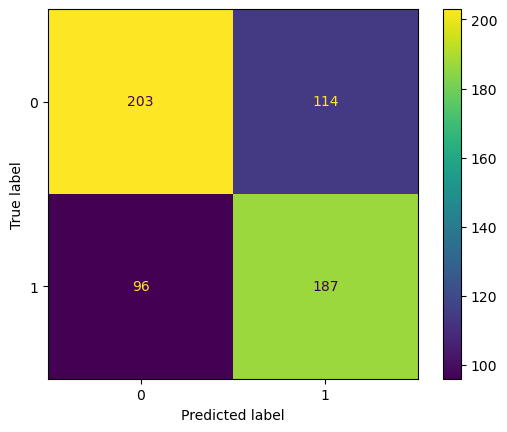

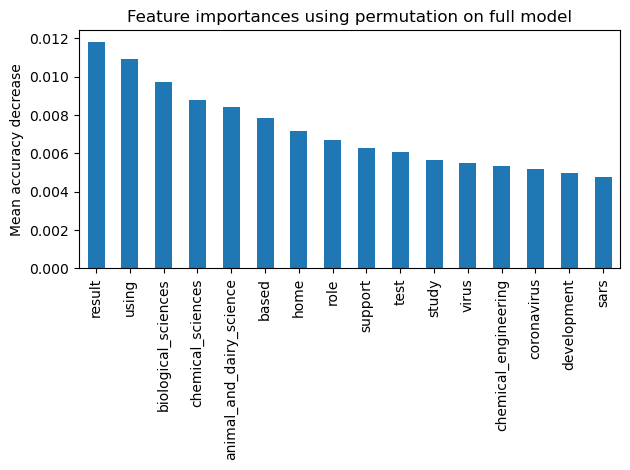

In [161]:
train_gbc(X_train=X_train_c19_comb, y_train=y_train_c19, X_test=X_test_c19_comb, y_test=y_test_c19)

The total space of parameters 288 is smaller than n_iter=2000. Running 288 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


"Best params: {'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 45, 'max_features': 'log2', 'max_depth': 40}"

'Gradient Boosting Classifier Accuracy score: 0.3925'

'Gradient Boosting Classifier Recall score: 0.38904895428965525'

'Gradient Boosting Classifier F1 score: 0.3772035943257988'

'Gradient Boosting Classifier Precision score: 0.38152747526379277'

'Gradient Boosting Classifier MAE score: 1.0675'

'Gradient Boosting Classifier RMSE score: 1.543534904043313'

'Gradient Boosting Classifier MSE score: 2.3825'

rigor                0.019250
show                 0.012083
aim                  0.009083
could                0.008833
data                 0.008500
large                0.007167
physical_sciences    0.006667
case                 0.006583
basic_medicine       0.006500
using                0.006167
activity             0.006000
range                0.006000
available            0.005833
provides             0.005667
chapter              0.005667
result               0.005583
dtype: float64

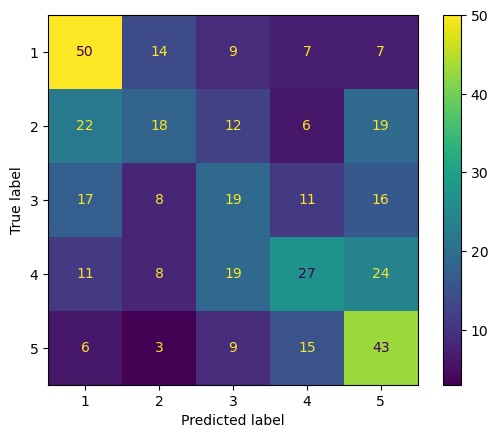

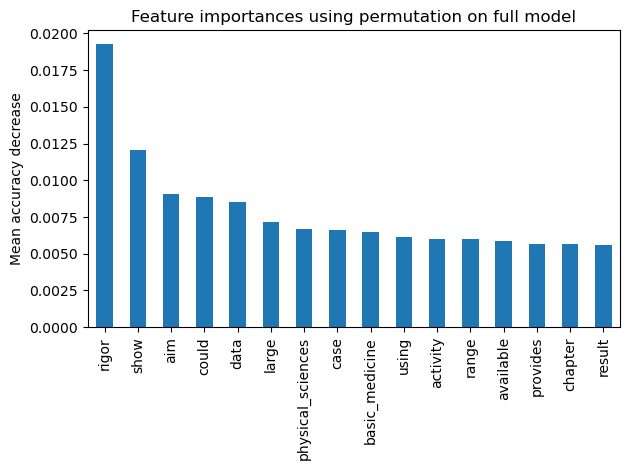

In [162]:
train_gbc(X_train_m17_comb, y_train_m17, X_test_m17_comb, y_test_m17)

The total space of parameters 20 is smaller than n_iter=2000. Running 20 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.


"Best params: {'n_estimators': 200, 'learning_rate': 0.1}"

'Ada Boosting Classifier Accuracy score: 0.3125'

'Ada Boosting Classifier Recall score: 0.3174236964448779'

'Ada Boosting Classifier F1 score: 0.31166989676497864'

'Ada Boosting Classifier Precision score: 0.330935651497406'

'Ada Boosting Classifier MAE score: 1.0275'

'Ada Boosting Classifier RMSE score: 1.40089257261219'

'Ada Boosting Classifier MSE score: 1.9625'

KeyboardInterrupt: 

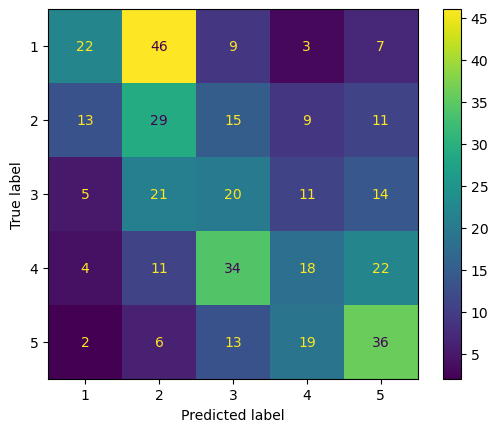

In [163]:
train_abc(X_train_m17_comb, y_train_m17, X_test_m17_comb, y_test_m17)

The total space of parameters 20 is smaller than n_iter=2000. Running 20 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.


"Best params: {'n_estimators': 100, 'learning_rate': 0.1}"

'Ada Boosting Classifier Accuracy score: 0.645'

'Ada Boosting Classifier Recall score: 0.6430036450379553'

'Ada Boosting Classifier F1 score: 0.6431672674374775'

'Ada Boosting Classifier Precision score: 0.6436232143656799'

'Ada Boosting Classifier MAE score: 0.355'

'Ada Boosting Classifier RMSE score: 0.5958187643906492'

'Ada Boosting Classifier MSE score: 0.355'

KeyboardInterrupt: 

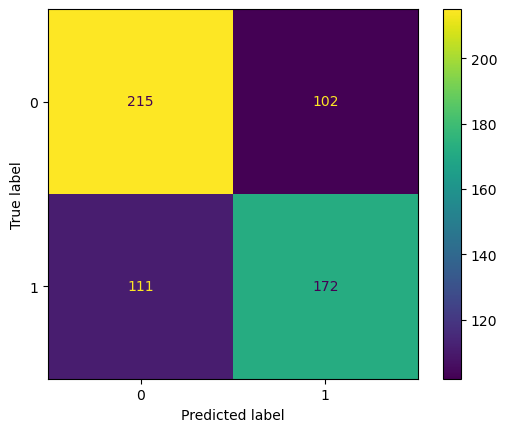

In [164]:
train_abc(X_train=X_train_c19_comb, y_train=y_train_c19, X_test=X_test_c19_comb, y_test=y_test_c19)

In [136]:
y_train_m17

129     1
1068    3
1832    5
697     2
1296    4
       ..
132     1
1889    5
869     3
1212    4
183     1
Name: evaluation, Length: 1400, dtype: int64

Epoch 1/150


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2223 - loss: 21.2942 - val_accuracy: 0.2688 - val_loss: 18.7186
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2295 - loss: 18.6815 - val_accuracy: 0.2125 - val_loss: 16.4918
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2354 - loss: 16.2402 - val_accuracy: 0.2188 - val_loss: 14.4021
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2778 - loss: 14.0764 - val_accuracy: 0.2125 - val_loss: 12.4958
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2854 - loss: 12.1648 - val_accuracy: 0.2188 - val_loss: 10.7954
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3153 - loss: 10.4438 - val_accuracy: 0.2281 - val_loss: 9.2684
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3046 - loss: 8.9409 - val_accuracy: 0.2313 - val_loss: 7.9565
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2832 - loss: 7.6661 - val_accuracy: 0.2438 - va

'Multilayer Perceptron with TF-IDF Accuracy score: 0.335'

'Multilayer Perceptron with TF-IDF Recall score: 0.32725151026284727'

'Multilayer Perceptron with TF-IDF F1 score: 0.3026981205290483'

'Multilayer Perceptron with TF-IDF Precision score: 0.34245952115517336'

'Multilayer Perceptron with TF-IDF MAE score: 1.015'

'Multilayer Perceptron with TF-IDF MSE score: 1.925'

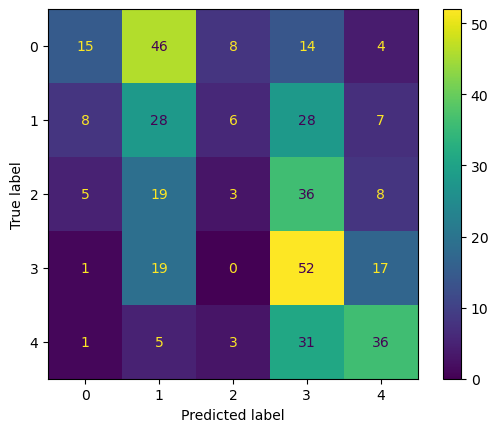

In [165]:
import tensorflow.keras as keras
from tensorflow.keras import regularizers

X_train = X_train_m17_comb
y_train = y_train_m17 - 1
X_test = X_test_m17_comb 
y_test = y_test_m17 - 1
# Split the data into training and testing set
# Build the neural network model
model = Sequential()

# First Dense layer with Batch Normalization

model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Second Dense layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Dropout with a probability of 0.5

# Output layer for 5-class classification
model.add(Dense(5, activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adamw', metrics=['accuracy'])

# Train the model
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, min_delta=0.002, restore_best_weights=True),
]
# Train the model
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred = np.argmax(model.predict(X_test), axis=1)

display(f"Multilayer Perceptron with TF-IDF Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF MAE score: {mean_absolute_error(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF MSE score: {mean_squared_error(y_test, y_pred)}")

get_conf_matrix(y_test=y_test, y_pred=y_pred)

Epoch 1/13


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4990 - loss: 18.9808 - val_accuracy: 0.4958 - val_loss: 14.1680
Epoch 2/13
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5128 - loss: 13.0230 - val_accuracy: 0.5125 - val_loss: 9.4863
Epoch 3/13
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5266 - loss: 8.6733 - val_accuracy: 0.5208 - val_loss: 6.2252
Epoch 4/13
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5594 - loss: 5.6574 - val_accuracy: 0.5042 - val_loss: 4.0843
Epoch 5/13
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5813 - loss: 3.7362 - val_accuracy: 0.5417 - val_loss: 2.8521
Epoch 6/13
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5857 - loss: 2.6362 - val_accuracy: 0.5458 - val_loss: 2.1827
Epoch 7/13
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6016 - loss: 2.1028 - val_accuracy: 0.6042 - val_loss: 1.9053
Epoch 8/13
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6229 - loss: 1.8446 - val_accuracy: 0.6458 - val_loss: 1.7670


'Multilayer Perceptron with TF-IDF Accuracy score: 0.6216666666666667'

'Multilayer Perceptron with TF-IDF Recall score: 0.6254695633757288'

'Multilayer Perceptron with TF-IDF F1 score: 0.6212869015874252'

'Multilayer Perceptron with TF-IDF Precision score: 0.6268939393939394'

'Multilayer Perceptron with TF-IDF MAE score: 0.37833333333333335'

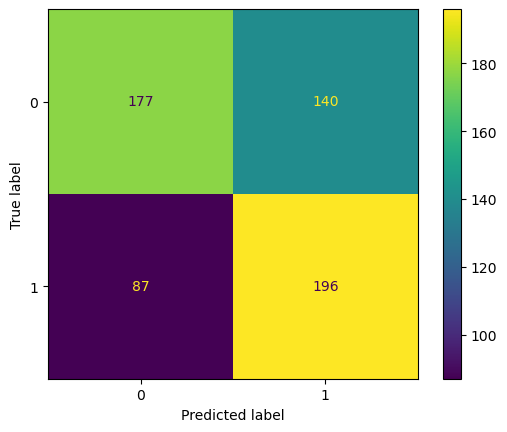

In [172]:
X_train = X_train_c19_comb
y_train = y_train_c19
X_test = X_test_c19_comb
y_test = y_test_c19


model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Second Dense layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Dropout with a probability of 0.5

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=13, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(f'Predictions: {y_pred.flatten()}')  # Predictions for binary classification

display(f"Multilayer Perceptron with TF-IDF Accuracy score: {accuracy_score(y_test, y_pred)}")
display(f"Multilayer Perceptron with TF-IDF Recall score: {recall_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF F1 score: {f1_score(y_test,  y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF Precision score: {precision_score(y_test, y_pred, average='macro')}")
display(f"Multilayer Perceptron with TF-IDF MAE score: {mean_absolute_error(y_test, y_pred)}")
get_conf_matrix(y_test=y_test, y_pred=y_pred)

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.


,novelty,rigor,grammar,replicability,accessibility,mathematics,computer_and_information_sciences,physical_sciences,chemical_sciences,earth_and_related_environmental_sciences,...,world,worldwide,would,wt,year,yet,yield,young,zone,Intercept
0,0.010095,0.014113,-0.007919,0.009702,0.001608,0.006226,0.009357,0.009873,0.007860,0.004994,...,-0.000754,0.000095,-0.002222,-0.002131,-0.000097,0.004365,0.000952,-0.000403,-0.000908,-0.038966
1,0.003946,0.005651,-0.002831,0.003757,0.000305,0.002470,0.001942,0.002744,0.002258,0.004084,...,0.001387,0.001325,0.000163,0.001178,0.001655,0.000043,0.001808,-0.001887,0.000757,0.020888
2,-0.003262,-0.000095,-0.000530,0.001660,0.001228,-0.000840,0.000142,-0.000267,0.000449,0.001579,...,-0.000322,-0.000577,0.000351,0.002716,0.000758,-0.002265,0.001623,0.001577,-0.000636,0.044190
3,-0.006197,-0.007948,0.004507,-0.004713,0.000579,-0.002784,-0.004801,-0.005033,-0.004718,-0.004247,...,-0.001566,-0.001248,0.001624,0.000301,0.000321,0.000430,-0.001663,-0.000200,0.001669,-0.024705
4,-0.004582,-0.011721,0.006773,-0.010406,-0.003719,-0.005072,-0.006640,-0.007317,-0.005848,-0.006410,...,0.001255,0.000405,0.000083,-0.002064,-0.002636,-0.002573,-0.002720,0.000913,-0.000882,-0.001406


'Logreg Accuracy score: 0.3425'

'Logreg Recall score: 0.3428168195845919'

'Logreg F1 score: 0.3073650583902996'

'Logreg Precision score: 0.30690821902531507'

'Logreg MAE score: 1.125'

'Logreg RMSE score: 1.5811388300841898'

'Logreg MSE score: 2.5'

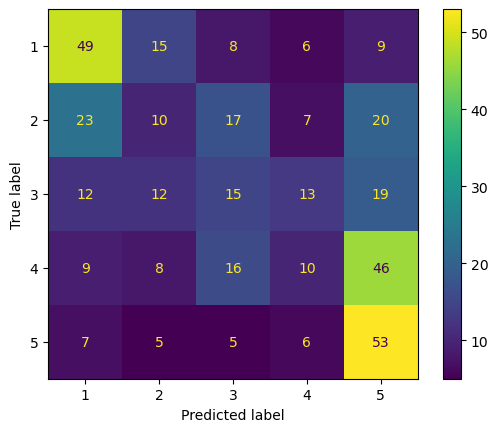

In [167]:
train_logreg(X_train_m17_comb, y_train_m17,X_test_m17_comb, y_test_m17)

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.


,rigor,novelty,grammar,replicability,accessibility,mathematics,computer_sciences,physical_sciences,chemical_sciences,earth_and_related_sciences,...,worldwide,would,wuhan,wuhan china,year,year old,yet,yield,young,Intercept
0,0.006221,0.002195,0.001017,0.001556,-0.000559,0.000591,0.00389,0.005851,0.007433,0.005375,...,0.002683,-0.002775,0.004419,0.003456,-0.005141,-0.006056,0.004662,0.001947,-0.000989,0.014738


'Logreg Accuracy score: 0.6533333333333333'

'Logreg Recall score: 0.656006509792556'

'Logreg F1 score: 0.6532986631996534'

'Logreg Precision score: 0.6564249868672531'

'Logreg MAE score: 0.3466666666666667'

'Logreg RMSE score: 0.5887840577551898'

'Logreg MSE score: 0.3466666666666667'

global health        0.005056
severe               0.004944
coronavirus          0.004778
education            0.004389
year old             0.004278
making               0.004167
outbreak             0.004111
rigor                0.004056
structural           0.003833
experience           0.003722
novel coronavirus    0.003556
leading              0.003444
image                0.003444
though               0.003444
coronavirus covid    0.003389
physical_sciences    0.003333
dtype: float64

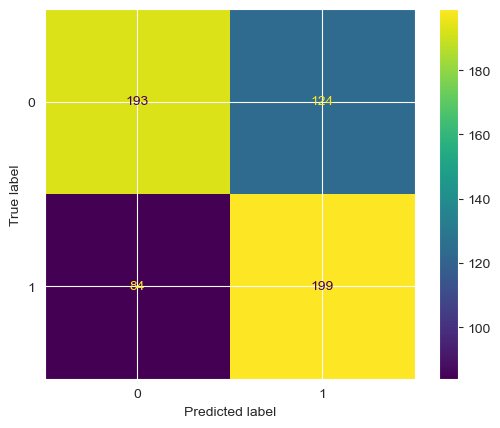

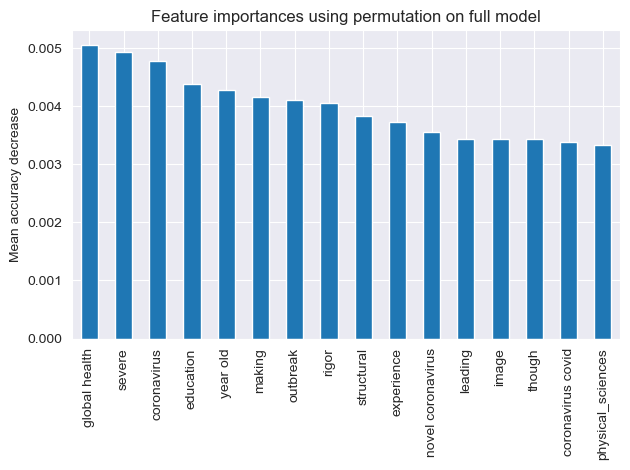

In [16]:
coeff = train_logreg(X_train=X_train_c19_comb, y_train=y_train_c19, X_test=X_test_c19_comb, y_test=y_test_c19)

In [33]:
coeff.T.sort_values(by=0, ascending=False).tail(15)

,0
applied,-0.005845
barrier,-0.005870
test,-0.005897
cancer,-0.005954
provider,-0.006016
network,-0.006055
year old,-0.006056
study,-0.006069
chapter,-0.006444
experience,-0.006523


Intercept                             0.014738
virus                                 0.009682
biological_sciences                   0.009374
basic_medicine                        0.009244
viral                                 0.008281
chemical_sciences                     0.007433
agriculture_forestry_and_fisheries    0.007283
animal_and_dairy_science              0.006987
host                                  0.006913
infection                             0.006754
replication                           0.006692
china                                 0.006663
molecule                              0.006637
veterinary_science                    0.006615
transmission                          0.006589
pathogen                              0.006332
Name: 0, dtype: float64

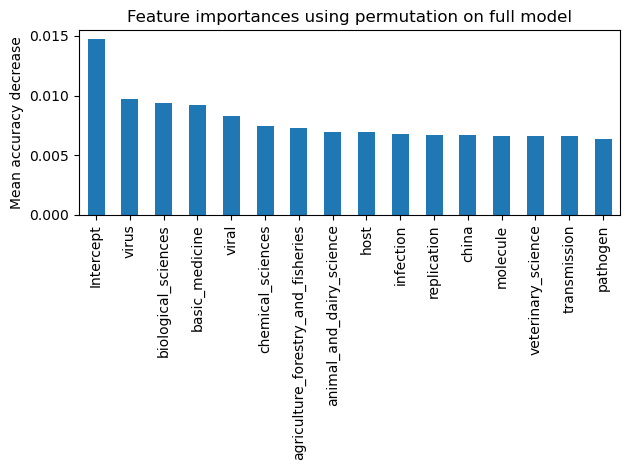

In [185]:

forest_importances = coeff.squeeze(axis=0).sort_values(ascending=False)[:16]
display(forest_importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

rigor            0.006221
novelty          0.002195
grammar          0.001017
replicability    0.001556
accessibility   -0.000559
                   ...   
year old        -0.006056
yet              0.004662
yield            0.001947
young           -0.000989
Intercept        0.014738
Name: 0, Length: 1563, dtype: float64

'SVM Accuracy score: 0.625'

'SVM Recall score: 0.6250236871732564'

'SVM F1 score: 0.6245400615754299'

'SVM Precision score: 0.6246443812233287'

'SVM MAE score: 0.375'

'SVM RMSE score: 0.6123724356957945'

'SVM MSE score: 0.375'

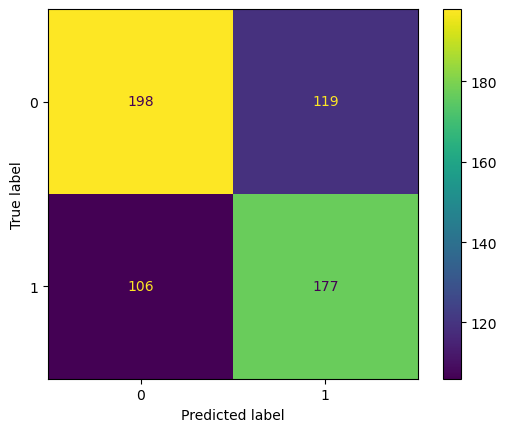

In [169]:
train_svm(X_train=X_train_c19_comb, y_train=y_train_c19, X_test=X_test_c19_comb, y_test=y_test_c19)

'SVM Accuracy score: 0.355'

'SVM Recall score: 0.34917671142188045'

'SVM F1 score: 0.33873546194251253'

'SVM Precision score: 0.3336155807853921'

'SVM MAE score: 1.035'

'SVM RMSE score: 1.4560219778561037'

'SVM MSE score: 2.12'

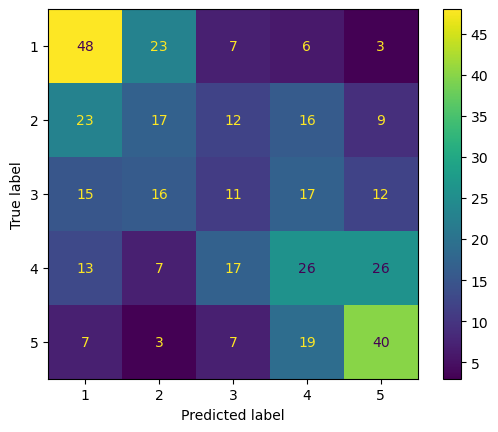

In [170]:
train_svm(X_train_m17_comb, y_train_m17,X_test_m17_comb, y_test_m17)

In [24]:
def train_logreg_shap(X_train, y_train, X_test, y_test, set):
    # Initialize the Gradient Boosting Classifier with specified parameters
    scaler = StandardScaler()
    X_train_orig = X_train
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test, )
    logistic_regression_cv_model = LogisticRegressionCV(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=10000,
        cv=5,
        random_state=42
    )
    logistic_regression_cv_model.fit(X_train, y_train)

    # Train the model

    # Predict on the test set
    y_pred = logistic_regression_cv_model.predict(X_test)

    # Display various metrics
    print(f"Gradient Boosting Classifier Accuracy score: {accuracy_score(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier Recall score: {recall_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier F1 score: {f1_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier Precision score: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier RMSE score: {mean_squared_error(y_test, y_pred, squared=False)}")

    # Function to display confusion matrix (assuming it's defined elsewhere)
    # Compute SHAP values
    explainer = shap.Explainer(logistic_regression_cv_model.predict, X_train, max_evals = 3000)
    shap_values = explainer(X_test)

    # Plot SHAP summary plot
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig(f"shap{set}.pdf", format="pdf", dpi=500, bbox_inches = "tight")
    plt.show()

Gradient Boosting Classifier Accuracy score: 0.6533333333333333
Gradient Boosting Classifier Recall score: 0.656006509792556
Gradient Boosting Classifier F1 score: 0.6532986631996534
Gradient Boosting Classifier Precision score: 0.6564249868672531
Gradient Boosting Classifier MAE score: 0.3466666666666667
Gradient Boosting Classifier MSE score: 0.3466666666666667
Gradient Boosting Classifier RMSE score: 0.5887840577551898


C:\SDKs\ml_venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
PermutationExplainer explainer: 601it [10:52,  1.10s/it]                         


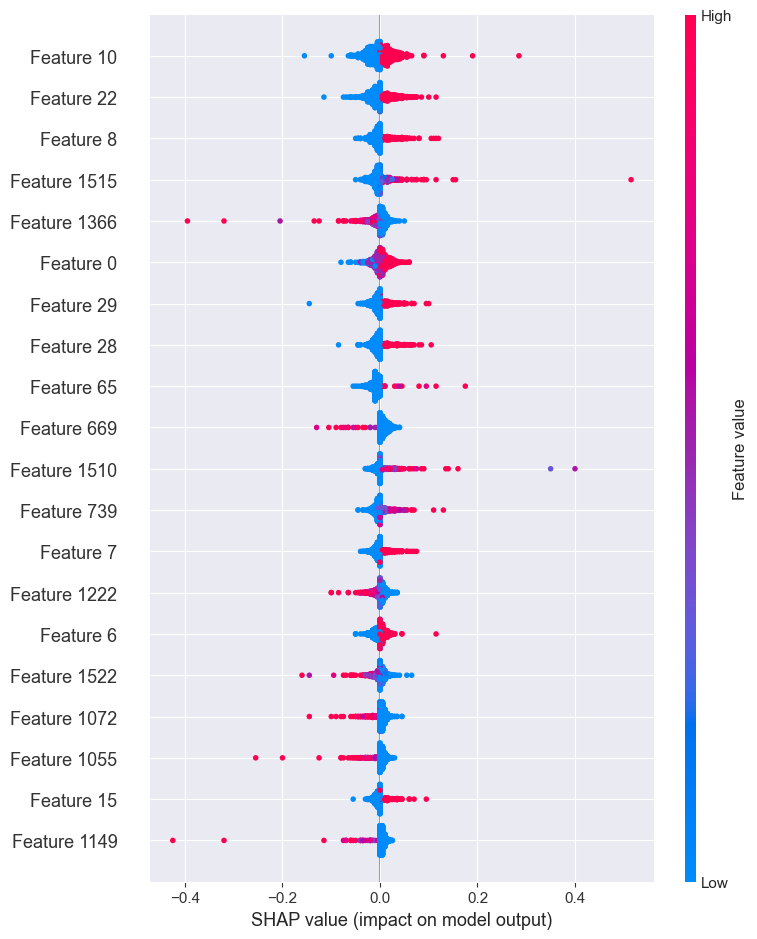

In [25]:
train_logreg_shap(X_train=X_train_c19_comb, y_train=y_train_c19, X_test=X_test_c19_comb, y_test=y_test_c19, set='c19')

Gradient Boosting Classifier Accuracy score: 0.3775
Gradient Boosting Classifier Recall score: 0.37192491929504923
Gradient Boosting Classifier F1 score: 0.3521997158805338
Gradient Boosting Classifier Precision score: 0.3568302387267904
Gradient Boosting Classifier MAE score: 1.0825
Gradient Boosting Classifier MSE score: 2.3925
Gradient Boosting Classifier RMSE score: 1.546770829825802


C:\SDKs\ml_venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
PermutationExplainer explainer: 401it [13:23,  2.03s/it]                         


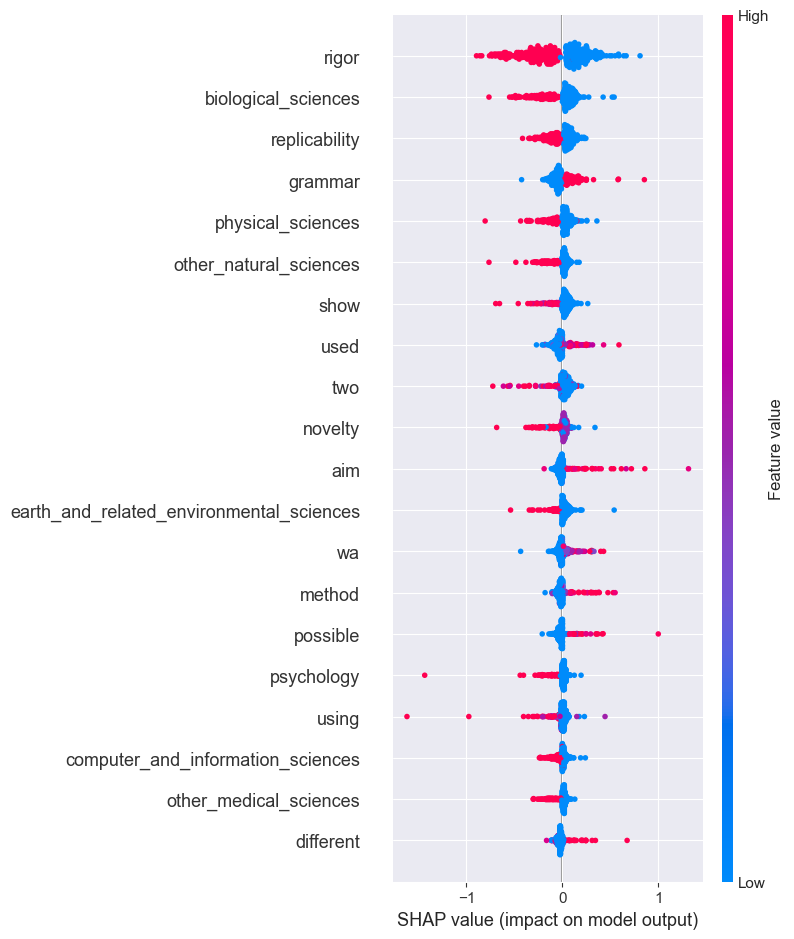

In [32]:
def train_gbc_shap(X_train, y_train, X_test, y_test, set):
    # Initialize the Gradient Boosting Classifier with specified parameters
    #'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 45, 'max_features': 'log2', 'max_depth': 40}"
    best = GradientBoostingClassifier( # C19
        n_estimators=100,
        min_samples_split=50,
        min_samples_leaf=45,
        max_features='log2',
        max_depth=40,
        random_state = 42
    )

    # Train the model
    best.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best.predict(X_test)

    # Display various metrics
    print(f"Gradient Boosting Classifier Accuracy score: {accuracy_score(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier Recall score: {recall_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier F1 score: {f1_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier Precision score: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier RMSE score: {mean_squared_error(y_test, y_pred, squared=False)}")

    # Function to display confusion matrix (assuming it's defined elsewhere)
    # Compute SHAP values
    explainer = shap.Explainer(best.predict, X_train, max_evals = 3000)
    shap_values = explainer(X_test)

    # Plot SHAP summary plot
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig(f"shap{set}.pdf", format="pdf", dpi=500, bbox_inches = "tight")
    plt.show()
train_gbc_shap(X_train_m17_comb, y_train_m17,X_test_m17_comb, y_test_m17, set = 'm17')

Gradient Boosting Classifier Accuracy score: 0.6633333333333333
Gradient Boosting Classifier Recall score: 0.663385760943474
Gradient Boosting Classifier F1 score: 0.6628800943490694
Gradient Boosting Classifier Precision score: 0.6629063628785774
Gradient Boosting Classifier MAE score: 0.33666666666666667
Gradient Boosting Classifier MSE score: 0.33666666666666667
Gradient Boosting Classifier RMSE score: 0.5802298395176404


C:\SDKs\ml_venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
PermutationExplainer explainer: 601it [17:02,  1.71s/it]                         


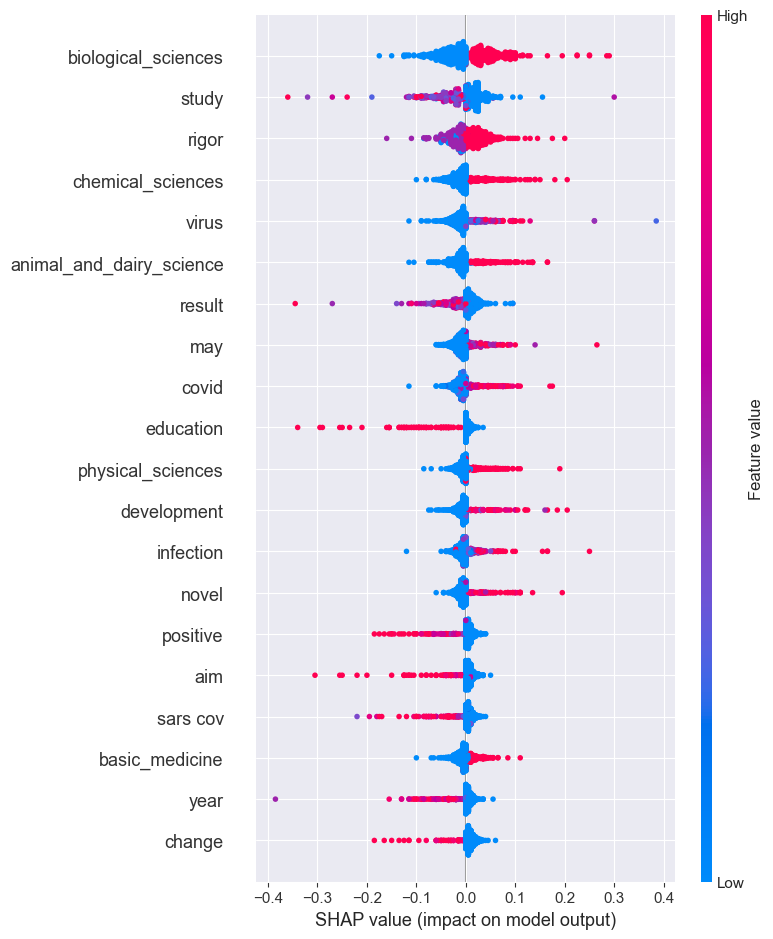

In [17]:
def train_gbc_shap(X_train, y_train, X_test, y_test, set):
    # Initialize the Gradient Boosting Classifier with specified parameters
    #'{'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 45, 'max_features': 'log2', 'max_depth': 40}"
    best = GradientBoostingClassifier( # C19
        n_estimators=100,
        min_samples_split=20,
        min_samples_leaf=45,
        max_features='log2',
        max_depth=40,
        random_state = 42
    )

    # Train the model
    best.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best.predict(X_test)

    # Display various metrics
    print(f"Gradient Boosting Classifier Accuracy score: {accuracy_score(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier Recall score: {recall_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier F1 score: {f1_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier Precision score: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Gradient Boosting Classifier MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"Gradient Boosting Classifier RMSE score: {mean_squared_error(y_test, y_pred, squared=False)}")

    # Function to display confusion matrix (assuming it's defined elsewhere)
    # Compute SHAP values
    explainer = shap.Explainer(best.predict, X_train, max_evals = 3000)
    shap_values = explainer(X_test)

    # Plot SHAP summary plot
    shap.summary_plot(shap_values, X_test, show=False)
    plt.savefig(f"shap{set}.pdf", format="pdf", dpi=500, bbox_inches = "tight")
    plt.show()
train_gbc_shap(X_train_c19_comb, y_train_c19,X_test_c19_comb, y_test_c19, set = 'c19')